<a href="https://colab.research.google.com/github/joaopaulo02/tennis-result-prediction/blob/main/model_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
''' libs importadas: ''' 

# categorical_features
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

# elo_features
import pandas as pd
import numpy as np

# main
from datetime import datetime,timedelta
import glob

# ml
import xgboost as xgb
import sklearn
from sklearn.model_selection import StratifiedKFold,KFold

# stategy_assessment
import seaborn as sns
import matplotlib.pyplot as plt

# utilities
import pickle

## Utilities

In [ ]:
# algumas funções úteis para armazenar e carregar dados

def dump(obj,name):
	pickle.dump(obj,open(name+'.p',"wb")) 
def load(name):
	obj=pickle.load( open( name+".p", "rb" ) ) 
	return obj

## Main

In [ ]:
# importação dos arquivos excel -> 1 por ano (do tennis.co.uk)
# alguns pré-processamentos são necessários porque por vários anos as probabilidades não estão presentes
# considerar odds do bet365 e do pinnacle

filenames=list(glob.glob("20*.xls*"))
l = [pd.read_excel(filename) for filename in filenames]
no_b365=[i for i,d in enumerate(l) if "B365W" not in l[i].columns]
no_pi=[i for i,d in enumerate(l) if "PSW" not in l[i].columns]
for i in no_pi:
    l[i]["PSW"]=np.nan
    l[i]["PSL"]=np.nan
for i in no_b365:
    l[i]["B365W"]=np.nan
    l[i]["B365L"]=np.nan
l=[d[list(d.columns)[:13]+["Wsets","Lsets","Comment"]+["PSW","PSL","B365W","B365L"]] for d in [l[0]]+l[2:]]
data=pd.concat(l,0)

### Data cleaning
data=data.sort_values("Date")
data["WRank"]=data["WRank"].replace(np.nan,0)
data["WRank"]=data["WRank"].replace("NR",2000)
data["LRank"]=data["LRank"].replace(np.nan,0)
data["LRank"]=data["LRank"].replace("NR",2000)
data["WRank"]=data["WRank"].astype(int)
data["LRank"]=data["LRank"].astype(int)
data["Wsets"]=data["Wsets"].astype(float)
data["Lsets"]=data["Lsets"].replace("`1",1)
data["Lsets"]=data["Lsets"].astype(float)
data=data.reset_index(drop=True)

display(data)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L
0,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,Semifinals,3,Schuettler R.,El Aynaoui Y.,47,33,2.0,1.0,Completed,NaN,NaN,NaN,NaN
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,Luxa P.,73,174,2.0,1.0,Completed,NaN,NaN,NaN,NaN
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,Dupuis A.,33,78,2.0,1.0,Completed,NaN,NaN,NaN,NaN
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,Arazi H.,206,35,2.0,0.0,Completed,NaN,NaN,NaN,NaN
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Caratti C.,Heuberger I.,211,219,2.0,1.0,Completed,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49259,22,Paris,French Open,2021-06-02,Grand Slam,Outdoor,Clay,2nd Round,5,Laaksonen H.,Bautista Agut R.,150,11,1.0,1.0,Completed,8.00,1.083,8.00,1.083
49260,22,Paris,French Open,2021-06-02,Grand Slam,Outdoor,Clay,2nd Round,5,Norrie C.,Harris L.,45,54,1.0,1.0,Completed,1.33,3.400,1.33,3.400
49261,22,Paris,French Open,2021-06-02,Grand Slam,Outdoor,Clay,2nd Round,5,Cilic M.,Federer R.,47,8,1.0,1.0,Completed,3.00,1.400,3.00,1.400
49262,22,Paris,French Open,2021-06-02,Grand Slam,Outdoor,Clay,2nd Round,5,Paul T.,Medvedev D.,52,2,1.0,1.0,Completed,3.20,1.360,3.20,1.360


## Categorical Features

In [ ]:
### as features "player1", "player2" and "Tournament" são tratadas diferentemente das outras features

def categorical_features_encoding(cat_features):
    """
    categorical features encoding.
    simple one-hot encoding.
    """
    cat_features = cat_features.apply(preprocessing.LabelEncoder().fit_transform)
    ohe = OneHotEncoder()
    cat_features = ohe.fit_transform(cat_features)
    cat_features = pd.DataFrame(cat_features.todense())
    cat_features.columns = ["cat_feature_"+str(i) for i in range(len(cat_features.columns))]
    cat_features = cat_features.astype(int)
    return cat_features

In [ ]:
def features_players_encoding(data):
    """
    encoding dos players . 

    os jogadores não são codificados como os outros recursos categóricos, 
    porque para cada jogo codificamos os dois jogadores ao mesmo tempo 
    (colocamos um 1 em cada linha correspondente para os jogadores que 
    jogam a partida,  para cada partida).
    """
    winners = data.Winner
    losers = data.Loser
    le = preprocessing.LabelEncoder()
    le.fit(list(winners) + list(losers))
    winners = le.transform(winners)
    losers = le.transform(losers)
    encod = np.zeros([len(winners),len(le.classes_)])
    for i in range(len(winners)):
        encod[i,winners[i]]+= 1
    for i in range(len(losers)):
        encod[i,losers[i]]+= 1
    columns = ["player_"+el for el in le.classes_]
    players_encoded = pd.DataFrame(encod, columns = columns)
    return players_encoded

features_players_encoding(data)

,player_ Hajek J.,player_Abdulla M.,player_Abel M.,player_Acasuso J.,player_Adaktusson J.,player_Adrian Mannarino,player_Agaev E.,player_Agassi A.,player_Agenor R.,player_Ager J.,player_Agostinelli B.,player_Aguilar J.,player_Ahouda A.,player_Al Ghareeb M.,player_Al Khulaifi N.G.,player_Al Mutawa J.,player_Al-Alawi S.K.,player_Al-Ghareeb M.,player_Alami K.,player_Alawadhi O.,player_Albert M.,player_Albert Ramos-Vinolas,player_Albot R.,player_Alcaide G.,player_Alcaraz C.,player_Aldi F.,player_Alejandro Davidovich Fokina,player_Alex De Minaur,player_Alex de Minaur,player_Alexander Bublik,player_Alexander Zverev,player_Alexei Popyrin,player_Alexei Popyrin,player_Ali Mutawa J.M.,player_Aljaz Bedene,player_Allegro Y.,player_Almagro N.,player_Almagro N.,player_Alonso J.,player_Altamirano C.,...,player_Youzhny M.,player_Yu X.Y.,player_Yuksel A.,player_Zabaleta M.,player_Zampieri C.,player_Zapata Miralles B.,player_Zayed M. S.,player_Zayid M. S.,player_Zayid M.S.,player_Zeballos H.,player_Zeballos H.,player_Zekic M.,player_Zemlja G.,player_Zeng S.X.,player_Zeppieri G.,player_Zhang Y.,player_Zhang Z.,player_Zhang Ze,player_Zhang Ze.,player_Zhang Zh.,player_Zhu B.Q.,player_Ziadi M.,player_Zib T.,player_Zimonjic N.,player_Zitko R.,player_Zlatanovic A.,player_Zopp J.,player_Zovko L.,player_Zuk K.,player_Zverev A.,player_Zverev A.,player_Zverev M.,player_de Chaunac S.,player_de Voest R.,player_di Mauro A.,player_di Pasquale A.,player_van Gemerden M.,player_van Lottum J.,player_van Scheppingen D.,player_van de Zandschulp B.
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.

In [ ]:
def features_tournaments_encoding(data):
    """
    encoding dos torneios. 
    """
    tournaments = data.Tournament
    le = preprocessing.LabelEncoder()
    tournaments = le.fit_transform(tournaments)
    encod = np.zeros([len(tournaments), len(le.classes_)])
    for i in range(len(tournaments)):
        encod[i,tournaments[i]]+=1
    columns=["tournament_"+el for el in le.classes_]
    tournaments_encoded = pd.DataFrame(encod,columns=columns)
    return tournaments_encoded

features_tournaments_encoding(data)

,tournament_AAPT Championships,tournament_ABN AMRO World Tennis Tournament,tournament_AEGON Championships,tournament_AEGON International,tournament_AEGON Open,tournament_AIG Japan Open Tennis Championships,tournament_ASB Classic,tournament_ATP Buenos Aires 2005,tournament_ATP Monte Carlo,tournament_ATP Vegeta Croatia Open,tournament_AXA Cup,tournament_Abierto Mexicano,tournament_Abierto Mexicano Mifel,tournament_Abierto Mexicano Telcel,tournament_Adelaide International,tournament_Allianz Suisse Open,tournament_Antalya Open,tournament_Apia International,tournament_Argentina Open,tournament_Astana Open,tournament_Atlanta Tennis Championships,tournament_Australian Hardcourt Championships,tournament_Australian Open,tournament_Austrian Open,tournament_BA-CA Tennis Trophy,tournament_BB&T Atlanta Open,tournament_BMW Open,tournament_BNP Paribas,tournament_BNP Paribas Masters,tournament_BNP Paribas Open,tournament_BRD Nastase Tiriac Trophy,tournament_Bellsouth Open,tournament_Bet-At-Home Cup,tournament_Brasil Open,tournament_Breil ATP,tournament_Brisbane International,tournament_CA Tennis Trophy,tournament_CAM Open Comunidad Valenciana,tournament_Campionati Internazional d'Italia,tournament_Campionati Internazionali Di Sicilia,...,tournament_St. Petersburg Open,tournament_Stella Artois,tournament_Stockholm Open,tournament_Studena Croatia Open,tournament_Stuttgart TMS,tournament_Suisse Open Gstaad,tournament_Swedish Open,tournament_Swiss Indoors,tournament_Sybase Open,tournament_Sydney International,tournament_Synsam Swedish Open,tournament_TATA Open,tournament_TD Waterhouse Cup,tournament_Tata Open,tournament_Telecom Italia Masters Roma,tournament_Tennis Int'l of San Marino,tournament_Thailand Open,tournament_The Hamlet Cup,tournament_The Nottingham Open,tournament_Topshelf Open,tournament_Torneo Godó,tournament_Toronto TMS,tournament_U.S. Clay Court Championships,tournament_U.S. Men's Clay Court Championships,tournament_U.S. National Indoor Tennis Championships,tournament_US Open,tournament_Unicef Open,tournament_VTR Open,tournament_Valencia Open 500,tournament_Verizon Tennis Challenge,tournament_Vietnam Open,tournament_Western & Southern Financial Group Masters,tournament_Wimbledon,tournament_Winston-Salem Open at Wake Forest University,tournament_Zhuhai Open,tournament_adidas International,tournament_adidas Open,tournament_bet-at-home Open,tournament_bett1HULKS Championship,tournament_bett1HULKS Indoors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Elo Features

In [ ]:
def compute_elo_rankings(data):
    """
    Given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    """

    print("Elo rankings computing...")
    players = list(pd.Series(list(data.Winner) + list(data.Loser)).value_counts().index)
    elo = pd.Series(np.ones(len(players))*1500,index = players)
    ranking_elo = [(1500,1500)]
    for i in range(1,len(data)):
        w = data.iloc[i-1,:].Winner
        l = data.iloc[i-1,:].Loser
        elow = elo[w]
        elol = elo[l]
        pwin = 1 / (1 + 10 ** ((elol - elow) / 400))    
        K_win = 32
        K_los = 32
        new_elow = elow+K_win*(1-pwin)
        new_elol = elol-K_los*(1-pwin)
        elo[w] = new_elow
        elo[l] = new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%5000==0:
            print(str(i) + " matches computed...")
    ranking_elo = pd.DataFrame(ranking_elo,columns = ["elo_winner","elo_loser"])    
    ranking_elo["proba_elo"] = 1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    return ranking_elo

## Past Features

In [ ]:
    """
    Cria recursos com base no passado dos jogadores.
    Basicamente, um loop for tira 1 partida por vez, seleciona as partidas que ocorreram durante
    seu passado próximo (geralmente 150 dias antes do máximo) e calcula alguns recursos.
    Cada partida aparecerá duas vezes no conjunto de dados: 1 vez por resultado da partida.

    Exemplo: 02/03/2016 Djoko-Zverev, Djoko venceu:

        Durante os 150 dias antes da partida, Djoko venceu 80% das partidas e Zverev 40%.
        Codificamos o resultado "Djoko vence" assim: [80,40] e informamos ao modelo que esse resultado aconteceu (1).
        Codificamos o resultado "Zverev vence" assim: [40,80] e informamos ao modelo que isso não aconteceu (0).

    E fazemos isso com mais alguns recursos, com base nas estatísticas anteriores dos jogadores na superfície
    da partida, sobre as lesões recentes, ...
    Nas entradas da função, "indexes" contém os índices das correspondências que queremos codificar.
    A saída das funções é duas vezes mais longa do que "indexes".
    """

def features_past_generation(features_creation_function,
                             days,
                             feature_names_prefix,
                             data,
                             indices):
  
  matches_outcomes=[]
  for i,match_indice in enumerate(indices):
        match=data.iloc[match_indice,:]
        past_matches=data[(data.Date<match.Date)&(data.Date>=match.Date-datetime.timedelta(days=days))]
        match_features_outcome_1=features_creation_function(1,match,past_matches)
        match_features_outcome_2=features_creation_function(2,match,past_matches)
        matches_outcomes.append(match_features_outcome_1)
        matches_outcomes.append(match_features_outcome_2)
        if i%100==0:
            print(str(i)+"/"+str(len(indices))+" matches treated.")
  train=pd.DataFrame(matches_outcomes)
  train.columns=[feature_names_prefix+str(i) for i in range(len(train.columns))]
  return train

In [ ]:
def features_player_creation(outcome,match,past_matches):
    features_player = []

    # extração das informações da partida (de acordo com o outcome)
    player = match.Winner if outcome == 1 else match.Loser
    surface = match.Surface

    # stats geral
    wins = past_matches[past_matches.Winner == player]    
    losses = past_matches[past_matches.Loser == player]    
    todo = pd.concat([wins,losses],0)
    features_player+=[len(wins),len(losses),len(todo)]
    per_victory = 100*len(wins)/len(todo) if len(todo)>0 else np.nan
    features_player.append(per_victory)

    # surface
    past_surface = past_matches[past_matches.Surface == surface]
    wins_surface = past_surface[past_surface.Winner == player]    
    losses_surface = past_surface[past_surface.Loser == player]    
    todo_surface = pd.concat([wins_surface,losses_surface],0)
    features_player+=[len(wins_surface),len(losses_surface),len(todo_surface)]
    per_victory_surface = 100*len(wins_surface)/len(todo_surface) if len(todo_surface)>0 else np.nan
    features_player.append(per_victory_surface)
    return features_player

In [ ]:
def features_recent_creation(outcome,match,past_matches):

    # extração das informações da partida (de acordo com o outcome)
    player = match.Winner if outcome == 1 else match.Loser
    date = match.Date

    # partidas anteriores
    wins = past_matches[past_matches.Winner == player]    
    losses = past_matches[past_matches.Loser == player]    
    todo = pd.concat([wins,losses],0)
    if len(todo) == 0:
        return [np.nan]*7

    # dias desde a última partida
    dslm = (date-todo.iloc[-1,:].Date).days

    # a última partida foi ganha?
    wlmw = int(todo.iloc[-1,:].Winner==player)

    # ranking do jogador da última partida
    rlpp=todo.iloc[-1,:].WRank

    # número de sets da última partida jogada    
    nslmp = todo.iloc[-1,:]['Best of']

    # número de sets ganhos durante a última partida jogada
    nswlmp = todo.iloc[-1,:]['Wsets'] if wlmw==1 else todo.iloc[-1,:]['Lsets']

    # lesões -> iitp + lesão última partida
    if len(losses)!=0:
        ilm = int(losses.iloc[-1,:].Comment == "Completed")
        iitp=1 if (losses.Comment != "Completed").sum()>0 else 0
    else:
        ilm = np.nan
        iitp = np.nan
    features_recent = [dslm, wlmw, rlpp, nslmp, nswlmp, ilm, iitp]
    return features_recent

In [ ]:
def features_duo_creation(outcome, match, past):
    features_duo = []

    # extração das informações da partida (de acordo com o outcome)
    player1 = match.Winner if outcome == 1 else match.Loser
    player2 = match.Loser if outcome == 1 else match.Winner

    # duo features geral
    # % dos jogos anteriores entre estes 2 jogadores vencidos por cada um.
    duo1 = past[(past.Winner == player1)&(past.Loser == player2)]    
    duo2 = past[(past.Winner == player2)&(past.Loser == player1)]    
    duo = pd.concat([duo1,duo2],0)
    features_duo+=[len(duo),len(duo1),len(duo2)]
    per_victory_player1 = 100*len(duo1)/len(duo) if len(duo)>0 else np.nan
    features_duo.append(per_victory_player1)
    return features_duo

In [ ]:
def features_general_creation(outcome,match,past_matches):
    features_general=[]

    # extração das informações da partida (de acordo com o outcome)
    player1 = match.Winner if outcome == 1 else match.Loser
    rank_player_1 = match.WRank if outcome == 1 else match.LRank
    rank_player_2 = match.LRank if outcome == 1 else match.WRank
    
    features_general+=[rank_player_1,rank_player_2,
                       rank_player_2-rank_player_1,
                       int(rank_player_1>rank_player_2)]

    best_ranking_as_winner = past_matches[(past_matches.Winner == player1)].WRank.min()
    best_ranking_as_loser = past_matches[(past_matches.Loser == player1)].LRank.min()
    best_ranking = min(best_ranking_as_winner,best_ranking_as_loser)
    features_general.append(best_ranking)
    return features_general

## Stategy Assessment

In [ ]:
def xgbModelBinary(xtrain,ytrain,xval,yval,p,sample_weights=None):
    """
    XGB model training. 
    Early stopping is performed using xval and yval (validation set).
    Outputs the trained model, and the prediction on the validation set
    """
    if sample_weights==None:
        dtrain=xgb.DMatrix(xtrain,label=ytrain)
    else:
        dtrain=xgb.DMatrix(xtrain,label=ytrain,weight=sample_weights)
    dval=xgb.DMatrix(xval,label=yval)
    eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
    params={'eval_metric':"logloss","objective":"binary:logistic",'subsample':0.8,
            'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
            'gamma':p[3],'eta':p[0],'colsample_bytree':p[4]}
    model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))
    return model

In [ ]:
def assessStrategyGlobal(test_beginning_match,
                         duration_train_matches,
                         duration_val_matches,
                         duration_test_matches,
                         xgb_params,
                         nb_players,
                         nb_tournaments,
                         features,
                         data,
                         model_name="0"):
    """
    Given the id of the first match of the testing set (id=index in the dataframe "data"),
    outputs the confidence dataframe.
    The confidence dataframe tells for each match is our prediction is right, and for
    the outcome we chose, the confidence level.
    The confidence level is simply the probability we predicted divided by the probability
    implied by the bookmaker (=1/odd).
    """
    ########## Training/validation/testing set generation
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)
    
    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
       
    train_indices=range(2*beg_train,2*end_train+2)
    val_indices=range(2*beg_val,2*end_val+2)
    test_indices=range(2*beg_test,2*end_test+2)
    
    if (len(test_indices)==0)|(len(train_indices)==0):
        return 0
    
    # Split in train/validation/test
    xval=features.iloc[val_indices,:].reset_index(drop=True)
    xtest=features.iloc[test_indices,:].reset_index(drop=True)
    xtrain=features.iloc[train_indices,:].reset_index(drop=True)
    ytrain=pd.Series([1,0]*int(len(train_indices)/2))   
    yval=pd.Series([1,0]*int(len(val_indices)/2))
    
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    
    # Biggest players 
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    # We drop smallest Tournaments and players
    xtrain=xtrain.drop(to_drop_players+to_drop_tournaments,1)
    xval=xval.drop(to_drop_players+to_drop_tournaments,1)
    xtest=xtest.drop(to_drop_players+to_drop_tournaments,1)

########################################################################################

    ### ML model training
    model=xgbModelBinary(xtrain,ytrain,xval,yval,xgb_params,sample_weights=None)

    # Transform the data columns (Winner, Loser) in a DataFrame
    winner_df = pd.DataFrame(data['Winner'],columns=['Winner'])
    loser_df = pd.DataFrame(data['Loser'],columns=['Loser'])
    date_df = pd.DataFrame(data['Date'],columns=['Date'])
    
    # The probability given by the model to each outcome of each match :
    pred_test= model.predict(xgb.DMatrix(xtest,label=None))
    pred_test_df = pd.DataFrame(pred_test,columns=['Previsão']) 

    # For each match, the winning probability the model gave to the players that won 
    prediction_test_winner=pred_test[range(0,len(pred_test),2)]
    pred_test_winner_df = pd.DataFrame(prediction_test_winner,columns=['prob_player_1']) 

    # For each match, the winning probability the model gave to the players that lost 
    prediction_test_loser=pred_test[range(1,len(pred_test),2)]
    pred_test_loser_df = pd.DataFrame(prediction_test_loser,columns=['prob_player_2'])

    # Putting predictions together in a DataFrame 
    pred_df = pd.concat([pred_test_winner_df, pred_test_loser_df], axis=1)
    pred_df.to_csv("prob_players.csv", index = False)

########################################################################################

    ### Odds and predicted probabilities for the testing set (1 row/match)
    odds=data[["B365W","B365L"]].iloc[range(beg_test,end_test+1)]
    implied_probabilities=1/odds
    p=pd.Series(list(zip(prediction_test_winner,prediction_test_loser,implied_probabilities.B365W,implied_probabilities.B365L)))

    ### For each match in the testing set, if the model predicted the right winner :
    right=(prediction_test_winner>prediction_test_loser).astype(int)
    ### For each match in the testing set, the confidence of the model in the outcome it chose
    def sel_match_confidence(x):
        if x[0]>x[1]:
            return x[0]/x[2] 
        else:
            return x[1]/x[3] 
    confidence=p.apply(lambda x:sel_match_confidence(x))
    
    ### The final confidence dataset 
    confidenceTest=pd.DataFrame({"match":range(beg_test,end_test+1),
                                 "win"+model_name:right,
                                 "confidence"+model_name:confidence,
                                 "B365W":odds.B365W.values})
    confidenceTest=confidenceTest.sort_values("confidence"+model_name,ascending=False).reset_index(drop=True)
    
    return confidenceTest

In [ ]:
def vibratingAssessStrategyGlobal(km,dur_train,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data):
    """
    The ROI is very sensistive to the training set. A few more matches in the training set can 
    change it in a non-negligible way. Therefore it is preferable to run assessStrategyGlobal several times
    with slights changes in the training set lenght, and then combine the predictions.
    This is what this function does.
    More precisely we compute the confidence dataset of 7 models with slightly different training sets.
    For each match, each model has an opinion of the winner, and a confidence is its prediction.
    For each match, the final chosen outcome is the outcome chosen by the most models (majority voting)
    And the final confidence is the average of the confidences of the models that chose this outcome.
    """
    confTest1=assessStrategyGlobal(km,dur_train,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"1")
    confTest2=assessStrategyGlobal(km,dur_train-10,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"2")
    confTest3=assessStrategyGlobal(km,dur_train+10,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"3")
    confTest4=assessStrategyGlobal(km,dur_train-30,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"4")
    confTest5=assessStrategyGlobal(km,dur_train+30,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"5")
    confTest6=assessStrategyGlobal(km,dur_train-45,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"6")
    confTest7=assessStrategyGlobal(km,dur_train+45,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"7")
    if (type(confTest1)!=int)&(type(confTest2)!=int)&(type(confTest3)!=int)&(type(confTest4)!=int)&(type(confTest5)!=int):
        c=confTest1.merge(confTest2,on=["match","B365W"])
        c=c.merge(confTest3,on=["match","B365W"])
        c=c.merge(confTest4,on=["match","B365W"])
        c=c.merge(confTest5,on=["match","B365W"])
        c=c.merge(confTest6,on=["match","B365W"])
        c=c.merge(confTest7,on=["match","B365W"])
        c=pd.Series(list(zip(c.win1,c.win2,c.win3,c.win4,c.win5,
                             c.win6,c.win7,
                             c.confidence1,c.confidence2,c.confidence3,
                             c.confidence4,c.confidence5,
                             c.confidence6,c.confidence7)))
        c=pd.DataFrame.from_records(list(c.apply(mer)))
        conf=pd.concat([confTest1[["match","B365W"]],c],1)
        conf.columns=["match","B365W","win0","confidence0"]
    else:
        conf=0
    return conf

In [ ]:
def mer(t):
    # If more than half the models choose the right outcome for the match, we can say
    # in real situation we would have been right. Otherwise wrong.
    # And the confidence in the chosen outcome is the mean of the confidences of the models
    # that chose this outcome.
    w=np.array([t[0],t[1],t[2],t[3],t[4],t[5],t[6]]).astype(bool)
    conf=np.array([t[7],t[8],t[9],t[10],t[11],t[12],t[13]])
    if w.sum()>=4:
        return 1,conf[w].mean()
    else:
        return 0,conf[~w].mean()

In [ ]:
def profitComputation(percentage,confidence,model_name="0"):
    """
    Input : percentage of matches we want to bet on,confidence dataset
    Output : ROI
    """
    tot_number_matches=len(confidence)
    number_matches_we_bet_on=int(tot_number_matches*(percentage/100))
    matches_selection=confidence.head(number_matches_we_bet_on)
    profit=100*(matches_selection.B365W[matches_selection["win"+model_name]==1].sum()-number_matches_we_bet_on)/number_matches_we_bet_on
    return profit

In [ ]:
def plotProfits(confidence,title=""):
    """
    Given a confidence dataset, plots the ROI according to the percentage of matches
    we bet on. 
    """
    profits=[]
    ticks=range(5,101)
    for i in ticks:
        p=profitComputation(i,confidence)
        profits.append(p)
    plt.plot(ticks,profits)
    plt.xticks(range(0,101,5))
    plt.xlabel("% of matches we bet on")
    plt.ylabel("Return on investment (%)")
    plt.suptitle(title)

## Training Model (Main pt.2)

In [ ]:

# elo rankings data
# computação do the elo ranking de cada player no começo de cada partida.
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)

data.to_csv("atp_data.csv", index = False)

# adicionando features para o dataset
data = pd.read_csv("atp_data.csv")
data.Date = data.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))


display(data.head())

Elo rankings computing...
5000 matches computed...
10000 matches computed...
15000 matches computed...
20000 matches computed...
25000 matches computed...
30000 matches computed...
35000 matches computed...
40000 matches computed...
45000 matches computed...


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,Semifinals,3,Schuettler R.,El Aynaoui Y.,47,33,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.50000
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,Luxa P.,73,174,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.50000
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,Dupuis A.,33,78,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1484.0,1500.0,0.47699
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,Arazi H.,206,35,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.50000
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Caratti C.,Heuberger I.,211,219,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.50000


In [ ]:
# o periodo que nos interessa 

beg = datetime(2008,1,1) 
end = data.Date.iloc[-1]
indices = data[(data.Date>beg)&(data.Date<=end)].index

print(indices)

Int64Index([20313, 20314, 20315, 20316, 20317, 20318, 20319, 20320, 20321,
            20322,
            ...
            49254, 49255, 49256, 49257, 49258, 49259, 49260, 49261, 49262,
            49263],
           dtype='int64', length=28951)


In [ ]:
import datetime

# construção de algumas features baseadas no passado 
features_player = features_past_generation(features_player_creation,5,"playerft5",data,indices)
features_duo = features_past_generation(features_duo_creation,150,"duoft",data,indices)
features_general = features_past_generation(features_general_creation,150,"generalft",data,indices)
features_recent  = features_past_generation(features_recent_creation,150,"recentft",data,indices)
dump(features_player,"player_features")
dump(features_duo,"duo_features")
dump(features_general,"general_features")
dump(features_recent,"recent_features")
features_player=load("player_features")
features_duo=load("duo_features")
features_general=load("general_features")
features_recent=load("recent_features")

0/28951 matches treated.
100/28951 matches treated.
200/28951 matches treated.
300/28951 matches treated.
400/28951 matches treated.
500/28951 matches treated.
600/28951 matches treated.
700/28951 matches treated.
800/28951 matches treated.
900/28951 matches treated.
1000/28951 matches treated.
1100/28951 matches treated.
1200/28951 matches treated.
1300/28951 matches treated.
1400/28951 matches treated.
1500/28951 matches treated.
1600/28951 matches treated.
1700/28951 matches treated.
1800/28951 matches treated.
1900/28951 matches treated.
2000/28951 matches treated.
2100/28951 matches treated.
2200/28951 matches treated.
2300/28951 matches treated.
2400/28951 matches treated.
2500/28951 matches treated.
2600/28951 matches treated.
2700/28951 matches treated.
2800/28951 matches treated.
2900/28951 matches treated.
3000/28951 matches treated.
3100/28951 matches treated.
3200/28951 matches treated.
3300/28951 matches treated.
3400/28951 matches treated.
3500/28951 matches treated.
3600

In [ ]:
# selecão do período 

data = data.iloc[indices,:].reset_index(drop=True)
odds = data[["B365W","B365L"]]

In [ ]:
# encoding da categorical features

features_categorical = data[["Series","Court","Surface","Round","Best of","Tournament"]]
features_categorical_encoded = categorical_features_encoding(features_categorical)
players_encoded = features_players_encoding(data)
tournaments_encoded = features_tournaments_encoding(data)
features_onehot = pd.concat([features_categorical_encoded,players_encoded,tournaments_encoded],1)

In [ ]:
# for the moment we have one row per match. 
# we "duplicate" each row to have one row for each outcome of each match. 
# of course it isn't a simple duplication of each row, we need to "invert" some features

# elo data
elo_rankings = data[["elo_winner","elo_loser","proba_elo"]]
elo_1 = elo_rankings
elo_2 = elo_1[["elo_loser","elo_winner","proba_elo"]]
elo_2.columns = ["elo_winner","elo_loser","proba_elo"]
elo_2.proba_elo = 1-elo_2.proba_elo
elo_2.index = range(1,2*len(elo_1),2)
elo_1.index = range(0,2*len(elo_1),2)
features_elo_ranking = pd.concat([elo_1,elo_2]).sort_index(kind='merge')

In [ ]:
# categorical features
features_onehot = pd.DataFrame(np.repeat(features_onehot.values,2, axis=0),columns=features_onehot.columns)

In [ ]:
# odds feature
features_odds = pd.Series(odds.values.flatten(),name="odds")
features_odds = pd.DataFrame(features_odds)

In [ ]:
# building of the final dataset
# you can remove some features to see the effect on the ROI
features = pd.concat([features_odds,
                  features_elo_ranking,
                  features_onehot,
                  features_player,
                  features_duo,
                  features_general,
                  features_recent],1)

features.to_csv("atp_data_features.csv",index=False)

[0]	train_loss-logloss:0.621439	eval-logloss:0.647422
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.567353	eval-logloss:0.611979
[2]	train_loss-logloss:0.526495	eval-logloss:0.592643
[3]	train_loss-logloss:0.500436	eval-logloss:0.589507
[4]	train_loss-logloss:0.478161	eval-logloss:0.591158
[5]	train_loss-logloss:0.461581	eval-logloss:0.590533
[6]	train_loss-logloss:0.443371	eval-logloss:0.592294
[7]	train_loss-logloss:0.421192	eval-logloss:0.590203
[8]	train_loss-logloss:0.403008	eval-logloss:0.585299
[9]	train_loss-logloss:0.387025	eval-logloss:0.587985
[10]	train_loss-logloss:0.380929	eval-logloss:0.588803
[11]	train_loss-logloss:0.3711	eval-logloss:0.58888
[12]	train_loss-logloss:0.358325	eval-logloss:0.589425
[13]	train_loss-logloss:0.344504	eval-logloss:0.59461
Stopping. Best iteration:
[8]	train_loss-logloss:0.403008	eval-logloss:0.585299

[0]	train_loss-

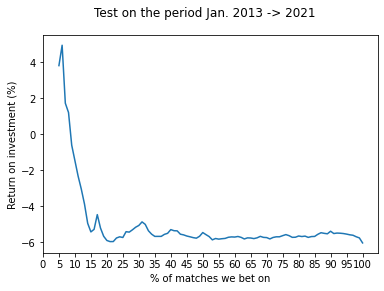

In [ ]:
################################################################################
#################### Strategy assessment - ROI computing #######################
################################################################################

# we adopt a sliding window method. We predict the outcome of delta consecutive matches , 
# with the N previous matches. A small subset of the training set is devoted to
# validation (the consecutive matches right before the testing matches)

######################### Confidence computing for each match ############################
features=pd.read_csv("atp_data_features.csv")

start_date=datetime.datetime(2013,1,1) #first day of testing set
test_beginning_match=data[data.Date==start_date].index[0] #id of the first match of the testing set
span_matches=len(data)-test_beginning_match+1
duration_val_matches=300
duration_train_matches=10400
duration_test_matches=2000

## Number of tournaments and players encoded directly in one-hot 
nb_players=50
nb_tournaments=5

## XGB parameters
learning_rate=[0.295] 
max_depth=[19]
min_child_weight=[1]
gamma=[0.8]
csbt=[0.5]
lambd=[0]
alpha=[2]
num_rounds=[300]
early_stop=[5]
params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
xgb_params=params[0]


## We predict the confidence in each outcome, "duration_test_matches" matches at each iteration
key_matches=np.array([test_beginning_match+duration_test_matches*i for i in range(int(span_matches/duration_test_matches)+1)])
confs=[]
for start in key_matches:
    conf=vibratingAssessStrategyGlobal(start,10400,duration_val_matches,duration_test_matches,xgb_params,nb_players,nb_tournaments,features,data)
    confs.append(conf)
confs=[el for el in confs if type(el)!=int]
conf=pd.concat(confs,0)
## We add the date to the confidence dataset (can be useful for analysis later)
dates=data.Date.reset_index()
dates.columns=["match","date"]
conf=conf.merge(dates,on="match")
conf=conf.sort_values("confidence0",ascending=False)
conf=conf.reset_index(drop=True)


## We store this dataset
conf.to_csv("confidence_data.csv",index=False)

## Plot of ROI according to the % of matches we bet on
plotProfits(conf,"Test on the period Jan. 2013 -> 2021")

Text(0, 0.5, 'For each section, number of matches we bet on')

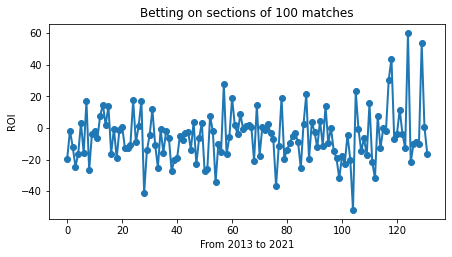

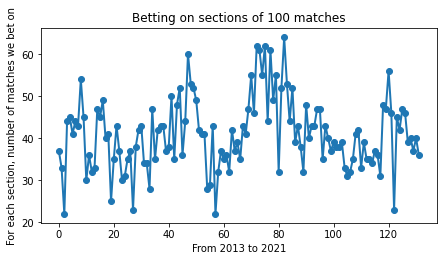

In [ ]:
################################################################################
######################### ROI variability along time ###########################
################################################################################

## We bet only on 35% of the matches
confconf=conf.iloc[:int(0.35*len(conf)),:]

def profitsAlongTime(conf,matches_delta):
    span_matches=span_matches=conf.match.max()-conf.match.min()-1
    N=int(span_matches/matches_delta)+1
    milestones=np.array([conf.match.min()+matches_delta*i for i in range(N)])
    profits=[]
    lens=[]
    for i in range(N-1):
        beg=milestones[i]
        end=milestones[i+1]-1
        conf_sel=confconf[(conf.match>=beg)&(conf.match<=end)]
        l=len(conf_sel)
        lens.append(l)
        if l==0:
            profits.append(0)
        else:    
            p=profitComputation(100,conf_sel)
            profits.append(p)
    profits=np.array(profits)
    return profits,lens

matches_delta=117
profits,lens=profitsAlongTime(confconf,matches_delta)

fig=plt.figure(figsize=(5.5,3))
ax = fig.add_axes([0,0,1,0.9])  
ax.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 100 matches")
ax.set_xlabel("From 2013 to 2021")
ax.set_ylabel("ROI")

fig=plt.figure(figsize=(5.5,3))
ax = fig.add_axes([0,0,1,0.9])  
ax.plot(lens,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 100 matches")
ax.set_xlabel("From 2013 to 2021")
ax.set_ylabel("For each section, number of matches we bet on")

## Working with the confidence data

In [ ]:
conf=pd.read_csv("confidence_data.csv")
print("Total number of matches predicted : "+str(len(conf)))

Total number of matches predicted : 15524


In [ ]:
conf.iloc[:6,:] 

,match,B365W,win0,confidence0,date
0,28023,34.00,1,23.730959,2020-10-01
1,28598,29.00,1,20.412278,2021-02-10
2,27253,29.00,1,20.051949,2020-01-23
3,28690,1.25,0,2.245382,2021-02-24
4,22325,1.33,0,2.129366,2017-05-09
5,21122,3.00,1,2.107323,2016-10-24


In [ ]:
def basic_horizontal_barplot(values,labels,xaxis_label,title,xlim=None,figsize=None):
    """
    Please provide the labels corresponding to the values, the plot title, and the xaxis label.
    """
    # Possible colors to use - if not enough, colors are reused
    cs=["coral","tomato","peachpuff","orange","gold","firebrick","peru","khaki","chocolate"]
    cs=cs*(len(values)//len(cs)+1)
    # The figure
    if figsize==None:
        fig=plt.figure(figsize=(4,3))
    else:
        fig=plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_axes([0,0,1,0.9])
    color=cs[:len(values)]
    ax.barh(range(len(values)),values,color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    if xlim!=None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)
    plt.show()

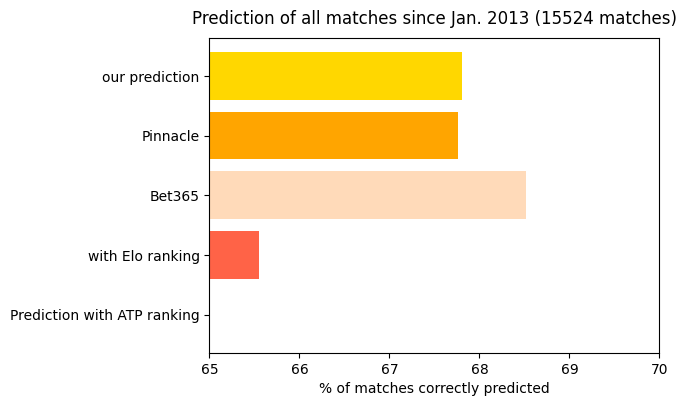

In [ ]:


# Comparison of different techniques for the winner prediction
# Interval for the comparison : [beg,end]
beg=datetime.datetime(2013,1,1)
end=data.Date.iloc[-1]
indices=data[(data.Date>=beg)&(data.Date<=end)].index
# classical ATP ranking
test=data[["WRank","LRank"]].iloc[indices,:]
atp=100*(test.LRank>test.WRank).sum()/len(indices)
# Elo ranking
test=data.iloc[indices,:]
elo=100*(test.elo_winner>test.elo_loser).sum()/len(indices)
# Bookmakers
test=data.iloc[indices,:]
book_pi=100*(test.PSW<test.PSL).sum()/len(indices)
book_365=100*(test.B365W<test.B365L).sum()/len(indices)
# Our prediction
our=100*conf.win0.sum()/len(conf)
# Plot
labels=["Prediction with ATP ranking","with Elo ranking",
        "Bet365","Pinnacle",
        "our prediction"]
values=[atp,elo,book_pi,book_365,our]
xaxis_label="% of matches correctly predicted"
title="Prediction of all matches since Jan. 2013 ("+str(len(indices))+" matches)"
xlim=[65,70]
basic_horizontal_barplot(values,labels,xaxis_label,title,xlim,figsize=(4.5,3.5))



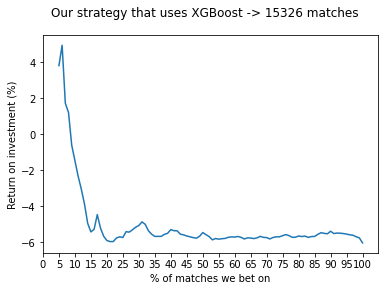

In [ ]:
plotProfits(conf,title="Our strategy that uses XGBoost -> 15326 matches")

In [ ]:
def profitsAlongTime(conf,matches_delta):
    span_matches=span_matches=conf.match.max()-conf.match.min()-1
    N=int(span_matches/matches_delta)+1
    milestones=np.array([conf.match.min()+matches_delta*i for i in range(N)])
    profits=[]
    lens=[]
    for i in range(N-1):
        beg=milestones[i]
        end=milestones[i+1]-1
        conf_sel=confconf[(conf.match>=beg)&(conf.match<=end)]
        l=len(conf_sel)
        lens.append(l)
        if l==0:
            profits.append(0)
        else:    
            p=profitComputation(100,conf_sel)
            profits.append(p)
    profits=np.array(profits)
    return profits,lens

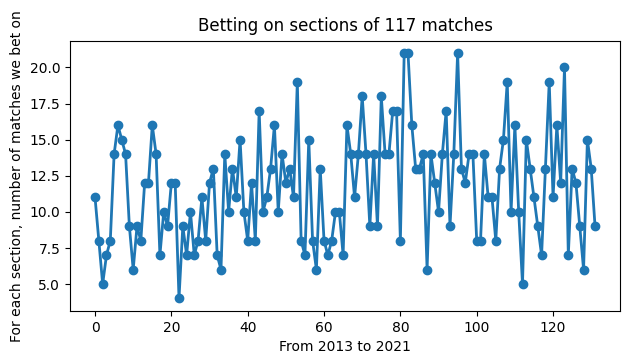

In [ ]:
confconf=conf.iloc[:int(0.1*len(conf)),:]
profits,lens=profitsAlongTime(confconf,117)
fig=plt.figure(figsize=(5.5,3),dpi=100)
ax = fig.add_axes([0,0,1,0.9])  
ax.plot(lens,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
ax.set_xlabel("From 2013 to 2021")
ax.set_ylabel("For each section, number of matches we bet on")
plt.show()

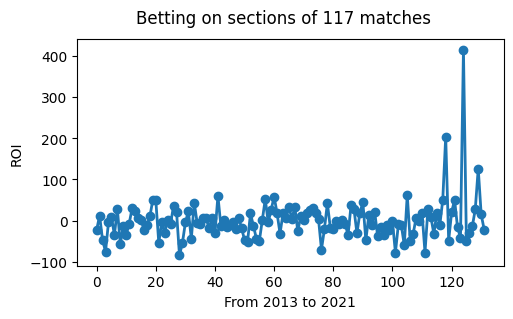

In [ ]:
conf10=conf.iloc[:int(0.1*len(conf)),:]
profits,lens=profitsAlongTime(conf10,117)
fig=plt.figure(figsize=(5.5,3),dpi=100)
plt.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
plt.xlabel("From 2013 to 2021")
plt.ylabel("ROI")
plt.show()

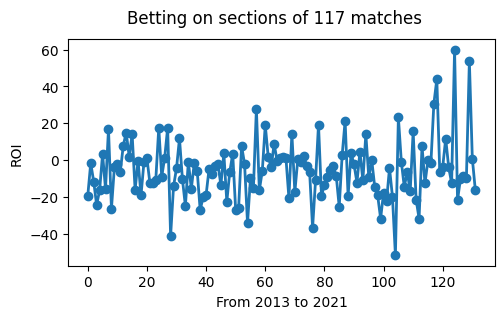

In [ ]:
confconf=conf.iloc[:int(0.35*len(conf)),:]
profits,lens=profitsAlongTime(confconf,117)
fig=plt.figure(figsize=(5.5,3),dpi=100)
plt.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
plt.xlabel("From 2013 to 2021")
plt.ylabel("ROI")
plt.show()

In [ ]:
print("Standard deviation : "+str(round(profits.std(),1)))

Standard deviation : 16.5


## Printing the predictions

In [ ]:
data.index.rename('match', inplace=True)

new_data = data.drop(columns=['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'WRank', 'LRank', 'Wsets', 'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'elo_winner', 'elo_loser', 'proba_elo'])

display(new_data)

,Winner,Loser,B365L
match,,,
0,Moya C.,Kudryavtsev A.,9.000
1,Murray A.,Schuettler R.,7.500
2,Wawrinka S.,Rochus C.,4.500
3,Tursunov D.,Kiefer N.,1.720
4,Sirianni J.,Querrey S.,1.360
...,...,...,...
28946,Laaksonen H.,Bautista Agut R.,1.083
28947,Norrie C.,Harris L.,3.400
28948,Cilic M.,Federer R.,1.400


In [ ]:
prob_players = pd.read_csv("prob_players.csv")

display(prob_players)

,prob_player_1,prob_player_2
0,0.893480,0.093113
1,0.635567,0.560980
2,0.835112,0.257715
3,0.556896,0.338533
4,0.336919,0.890386
...,...,...
1519,0.173216,0.864549
1520,0.567579,0.194272
1521,0.150228,0.835976
1522,0.104391,0.890494


In [ ]:
conf=pd.read_csv("confidence_data.csv")

conf_ord = conf.sort_values(by='match')

conf_df = pd.merge(conf_ord, new_data, how = 'inner', on = 'match')

conf_df = conf_df.rename(columns={'Winner': 'player_1', 'Loser': 'player_2', 'win0': 'player_1_wins', 'B365W': 'odds_player_1', 'B365L': 'odds_player_2', 'confidence0': 'confidence'})

conf_df = conf_df[['match', 'confidence', 'date', 'player_1', 'player_2', 'odds_player_1', 'odds_player_2', 'player_1_wins']]

conf_df.loc[conf_df['player_1_wins'] == 1, 'bet_on'] = conf_df['player_1'] 
conf_df.loc[conf_df['player_1_wins'] == 0, 'bet_on'] = conf_df['player_2'] 

conf_df.drop('player_1_wins', axis='columns', inplace=True)

conf_df.sort_values("confidence", axis = 0, ascending = True, inplace = True, na_position ='last')

match_pred = conf_df[conf_df.date == "2021-06-02"]

last_lines = match_pred.loc[match_pred['confidence']>=1.3]                            
match_pred.drop(match_pred.loc[match_pred['confidence']>=1.3].index, inplace=True)
new_match_pred=match_pred.loc[match_pred['confidence']<=0.95].append(last_lines,ignore_index=True)
match_pred.drop(match_pred.loc[match_pred['confidence']<=0.95].index, inplace=True)

df1 = pd.concat([new_match_pred, last_lines], ignore_index=True, sort=False)

match_pred = pd.concat([df1, match_pred], ignore_index=True, sort=False)

match_pred['date'] = match_pred['date'].replace(['2021-06-02'],'2021-06-02')

match_pred.to_csv("predicted_data.csv", index = False)

display(match_pred)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,match,confidence,date,player_1,player_2,odds_player_1,odds_player_2,bet_on
0,28947,0.845437,2021-06-02,Norrie C.,Harris L.,1.33,3.400,Norrie C.
1,28946,0.938526,2021-06-02,Laaksonen H.,Bautista Agut R.,8.00,1.083,Bautista Agut R.
2,28945,0.963370,2021-06-02,Tsitsipas S.,Martinez P.,1.04,13.000,Tsitsipas S.
3,28950,1.116531,2021-06-02,Krajinovic F.,Isner J.,1.80,2.000,Krajinovic F.
4,28948,1.151157,2021-06-02,Cilic M.,Federer R.,3.00,1.400,Federer R.
5,28949,1.158222,2021-06-02,Paul T.,Medvedev D.,3.20,1.360,Medvedev D.


In [ ]:
# conf_df['bet'].value_counts().plot.bar()

## Model Validation

In [ ]:
# acurácia
print(f"Acurácia: {conf.win0.sum()/len(conf)}")

Acurácia: 0.6728221910550102


In [ ]:
def get_confusion_matrix(reais, preditos, labels):
 
    # não implementado
    if len(labels) > 2:
        return None

    if len(reais) != len(preditos):
        return None
    
    # considerando a primeira classe como a positiva, e a segunda a negativa
    true_class = labels[0]
    negative_class = labels[1]

    # valores preditos corretamente
    tp = 0
    tn = 0
    
    # valores preditos incorretamente
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]

        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
    
    return np.array([
        # valores da classe positiva
        [ tp, fp ],
        # valores da classe negativa
        [ fn, tn ]
    ])

In [ ]:
get_confusion_matrix(reais=data, preditos=conf, labels=[1,0])